In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import tqdm

In [2]:
torch.manual_seed(1234)
random.seed(1234)
np.random.seed(1234)

In [3]:
mean = 0.13066048920154572
std = 0.30810779333114624

train_transforms = transforms.Compose([
                            transforms.RandomRotation(5),
                            transforms.RandomCrop(28, padding = 2),
                            transforms.ToTensor(),
                            transforms.Normalize(mean = [mean], std = [std])])

train_data = datasets.MNIST(root = '.data', 
                            train = True, 
                            download = True, 
                            transform = train_transforms)

In [4]:
batch_size = 128

train_iterator = data.DataLoader(train_data, 
                                 shuffle = True, 
                                 batch_size = batch_size)

In [5]:
class MLP(nn.Module):
    def __init__(self, input_dim, hid_dim, output_dim):
        super().__init__()
        self.layer1 = nn.Linear(input_dim, hid_dim)
        self.layer2 = nn.Linear(hid_dim, hid_dim)
        self.layer3 = nn.Linear(hid_dim, output_dim)
        self.init_params()

    def init_params(self):
        for n, p in self.named_parameters():
            if 'weight' in n:
                nn.init.kaiming_normal_(p, nonlinearity='relu')
            elif 'bias' in n:
                nn.init.constant_(p, 0)

    def forward(self, x):
        # x = [batch size, channels, height, width]
        batch_size, *_ = x.shape
        x = x.view(batch_size, -1)
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = self.layer3(x)
        return x

In [6]:
input_dim = 28 * 28
hid_dim = 256
output_dim = 10

model = MLP(input_dim, hid_dim, output_dim)

In [7]:
criterion = nn.CrossEntropyLoss()

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = model.to(device)
criterion = criterion.to(device)

In [9]:
def train_epoch(iterator, model, optimizer, criterion, device):
    
    losses = []

    for images, labels in tqdm.tqdm(iterator):
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        predictions = model(images)
        loss = criterion(predictions, labels)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

    return losses

In [10]:
def train(train_iterator, model, optimizer, criterion, device, n_epochs=10):

    losses = []

    model.init_params()

    for epoch in range(n_epochs):
        epoch_losses = train_epoch(train_iterator, model, optimizer, criterion, device)
        losses.extend(epoch_losses)

    return losses

In [11]:
def plot_loss(loss, title=None, ymin=0, ymax=None):
    fig, ax = plt.subplots()
    ax.plot(loss)
    ax.set_title(title)
    ax.set_ylabel('Loss')
    ax.set_xlabel('Update Steps')
    ax.set_ylim(ymin=ymin, ymax=ymax)
    ax.grid()

## Optimizer 1: Stochastic Gradient Descent (SGD)

$$\theta_{t+1} = \theta_t - \eta \cdot \nabla_\theta J(\theta_t)$$

However, we don't just have one set of parameters, $\theta$, we have multiple parameters because we have the weights of layer 1, the biases of layer 1, the weights of layer 2, the biases of layer 2, etc. So we'll subscript the parameters with $i$:

$$\theta_{t+1,i} = \theta_{t,i} - \eta \cdot \nabla_\theta J(\theta_{t,i})$$

In English:
- $\theta$ is your model parameters
- $\eta$ is the learning rate
- $\nabla_\theta$ is the gradient of the parameters
- $J$ is the loss function
- $\nabla_\theta J(\theta)$ is the gradient of the parameters with respect to the loss achived by those parameters

We subtract because we want to descend the gradient by moving towards the nearby minima. Addition would ascend the gradient.

In [12]:
class SGD:
    def __init__(self, model_params, lr=1e-3):
        self.model_params = list(model_params)
        self.lr = lr

    def zero_grad(self):
        for param in self.model_params:
            param.grad = None

    @torch.no_grad()
    def step(self):
        for param in self.model_params:
            param.sub_(self.lr * param.grad)

In [13]:
optimizer = SGD(model.parameters())

In [14]:
sgd_loss = train(train_iterator, model, optimizer, criterion, device)

100%|██████████| 469/469 [00:09<00:00, 47.51it/s]


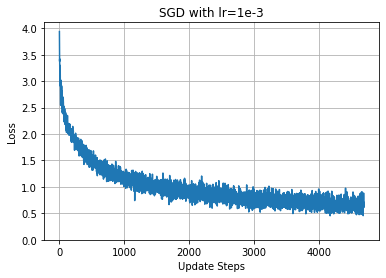

In [15]:
plot_loss(sgd_loss, 'SGD with lr=1e-3')

## Optimizer 2: SGD with Momentum

\begin{align*}
    v_{t,i} &= \gamma \cdot v_{t-1,i} + \eta \cdot \nabla_\theta J(\theta_{t,i})\\
    \theta_{t+1,i} &= \theta_{t,i} - v_{t,i}\\
\end{align*}

In English:
- $\gamma$ is the momentum
- $v$ is the velocity

In PyTorch they actually do (notice that $\eta$ has moved outside the equation for $v_t$):

\begin{align*}
    v_{t,i} &= \gamma \cdot v_{t-1,i} + \nabla_\theta J(\theta_{t,i})\\
    \theta_{t+1,i} &= \theta_{t,i} - \eta \cdot v_{t,i}\\
\end{align*}

We copy the PyTorch implementation.

In [16]:
class SGDMomentum:
    def __init__(self, model_params, lr=1e-3, momentum=0.9):
        self.model_params = list(model_params)
        self.lr = lr
        self.momentum = momentum
        self.v = [torch.zeros_like(p) for p in self.model_params]

    def zero_grad(self):
        for param in self.model_params:
            param.grad = None

    @torch.no_grad()
    def step(self):
        for param, v in zip(self.model_params, self.v):
            v.mul_(self.momentum).add_(param.grad)
            param.sub_(self.lr * v)

In [17]:
optimizer = SGDMomentum(model.parameters())

In [18]:
sgd_momentum_loss = train(train_iterator, model, optimizer, criterion, device)

100%|██████████| 469/469 [00:08<00:00, 53.20it/s]


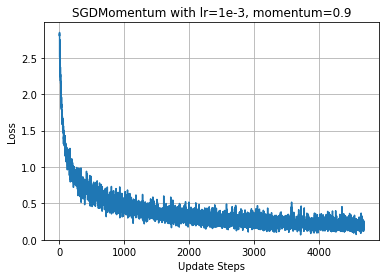

In [19]:
plot_loss(sgd_momentum_loss, 'SGDMomentum with lr=1e-3, momentum=0.9')

## Optimizer 3: Nesterov Accelerated Gradient (NAG)

\begin{align*}
    v_{t,i} &= \gamma \cdot v_{t-1,i} + \eta \cdot \nabla_\theta J(\theta_{t,i} - \gamma \cdot v_{t-1,i})\\
    \theta_{t+1,i} &= \theta_{t,i} - v_{t,i}\\
\end{align*}

Update parameters based on what the loss will be after the parameter update.

In PyTorch they actually do:

\begin{align*}
    v_{t,i} &= \gamma \cdot v_{t-1,i} + \nabla_\theta J(\theta_{t,i})\\
    \theta_{t+1,i} &= \theta_{t,i} - \eta \cdot \Big(\nabla_\theta J(\theta_{t,i}) + \gamma \cdot v_{t,i} \Big)\\
\end{align*}

We copy the PyTorch implementation.

In [20]:
class NAG:
    def __init__(self, model_params, lr=1e-3, momentum=0.9):
        self.model_params = list(model_params)
        self.lr = lr
        self.momentum = momentum
        self.v = [torch.zeros_like(p) for p in self.model_params]

    def zero_grad(self):
        for param in self.model_params:
            param.grad = None

    @torch.no_grad()
    def step(self):
        for param, v in zip(self.model_params, self.v):
            v.mul_(self.momentum).add_(param.grad)
            param.sub_(self.lr * (param.grad + v * self.momentum))

In [21]:
optimizer = NAG(model.parameters())

In [22]:
nag_loss = train(train_iterator, model, optimizer, criterion, device)

100%|██████████| 469/469 [00:09<00:00, 51.13it/s]


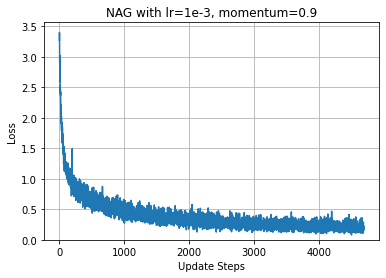

In [23]:
plot_loss(nag_loss, 'NAG with lr=1e-3, momentum=0.9')

In [24]:
def plot_losses(losses, labels, title=None, ymin=0, ymax=None):
    fig, ax = plt.subplots()
    for loss, label in zip(losses, labels):
        ax.plot(loss, label=label)
    ax.set_title(title)
    ax.set_ylabel('Loss')
    ax.set_xlabel('Update Steps')
    ax.set_ylim(ymin=ymin, ymax=ymax)
    ax.grid()
    ax.legend(loc='upper right')

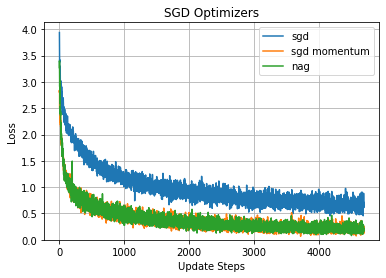

In [25]:
losses = [sgd_loss, sgd_momentum_loss, nag_loss]
labels = ['sgd', 'sgd momentum', 'nag']

plot_losses(losses, labels, 'SGD Optimizers')

## Optimizer 4: Adagrad

\begin{align*}
    \theta_{t+1,i} &= \theta_{t,i} - \frac{\eta}{\sqrt{G_{t,i}}+\epsilon} \cdot \nabla_\theta J(\theta_{t,i})\\
\end{align*}

where:

$$G_{t,i} = G_{t-1,i} + \Big(\nabla_\theta J(\theta_{t,i})\Big)^2$$

In English:
- $G_t$ is the sum of the square of the gradients so far, initialized to some value - zeros by default
- $\epsilon$ is very small number, used to avoid division by zero

In [26]:
class Adagrad:
    def __init__(self, model_params, lr=1e-2, init_G=0, eps=1e-10):
        self.model_params = list(model_params)
        self.lr = lr
        self.G = [torch.full_like(p, init_G) for p in self.model_params]
        self.eps = eps

    def zero_grad(self):
        for param in self.model_params:
            param.grad = None

    @torch.no_grad()
    def step(self):
        for param, g in zip(self.model_params, self.G):
            g.add_(param.grad * param.grad)
            std = g.sqrt().add(self.eps)
            param.sub_((self.lr / std) * param.grad)

In [27]:
optimizer = Adagrad(model.parameters())

In [28]:
adagrad_loss = train(train_iterator, model, optimizer, criterion, device)

100%|██████████| 469/469 [00:09<00:00, 49.60it/s]


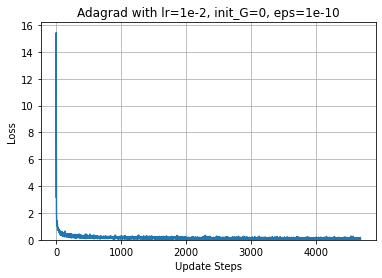

In [29]:
plot_loss(adagrad_loss, 'Adagrad with lr=1e-2, init_G=0, eps=1e-10')

Large spike is due to initial $G$ being very small and thus the learning rate is divided by a very small number, making it very large. 

Large learning usually give higher losses.

Let's trim the start to get a better view what the final loss value is.

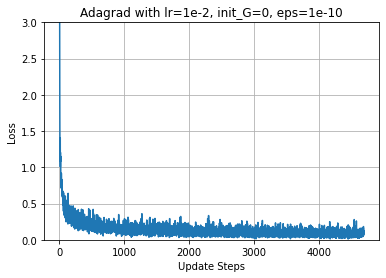

In [30]:
plot_loss(adagrad_loss, 'Adagrad with lr=1e-2, init_G=0, eps=1e-10', ymax=3.0)

We don't really mind the large spike at the start as long as the final loss is good, but let's try some different initial values for $G$ and store them all in a `adagrad_losses` dictionary with the key being the initial $G$ value and the values being a list of training loss per batch.

In [31]:
adagrad_losses = {0: adagrad_loss}

In [32]:
optimizer = Adagrad(model.parameters(), init_G=1.0)

In [33]:
adagrad_losses[1.0] = train(train_iterator, model, optimizer, criterion, device)

100%|██████████| 469/469 [00:09<00:00, 50.51it/s]


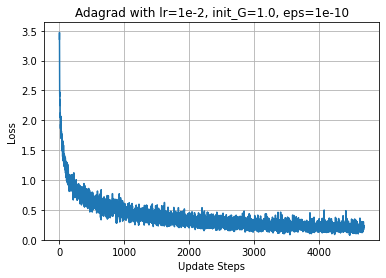

In [34]:
plot_loss(adagrad_losses[1.0], 'Adagrad with lr=1e-2, init_G=1.0, eps=1e-10')

In [35]:
optimizer = Adagrad(model.parameters(), init_G=0.1)

In [36]:
adagrad_losses[0.1] = train(train_iterator, model, optimizer, criterion, device)

100%|██████████| 469/469 [00:11<00:00, 42.09it/s]


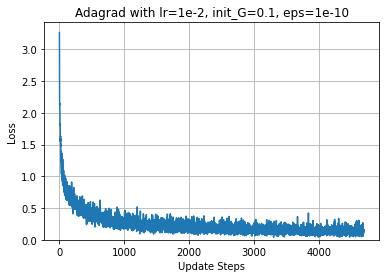

In [37]:
plot_loss(adagrad_losses[0.1], 'Adagrad with lr=1e-2, init_G=0.1, eps=1e-10')

In [38]:
optimizer = Adagrad(model.parameters(), init_G=0.01)

In [39]:
adagrad_losses[0.01] = train(train_iterator, model, optimizer, criterion, device)

100%|██████████| 469/469 [00:11<00:00, 40.01it/s]


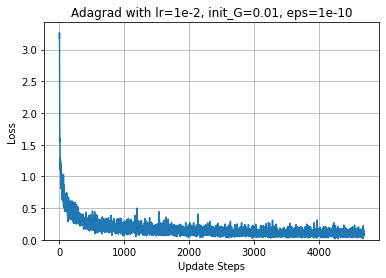

In [40]:
plot_loss(adagrad_losses[0.01], 'Adagrad with lr=1e-2, init_G=0.01, eps=1e-10')

In [41]:
optimizer = Adagrad(model.parameters(), init_G=0.001)

In [42]:
adagrad_losses[0.001] = train(train_iterator, model, optimizer, criterion, device)

100%|██████████| 469/469 [00:09<00:00, 50.26it/s]


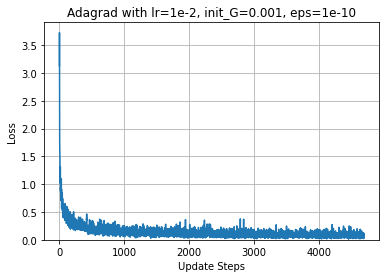

In [43]:
plot_loss(adagrad_losses[0.001], 'Adagrad with lr=1e-2, init_G=0.001, eps=1e-10')

Now let's compare all of our four values for the initial $G$ value.

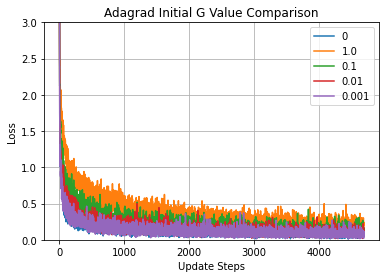

In [44]:
labels, losses = zip(*adagrad_losses.items())

plot_losses(losses, labels, 'Adagrad Initial G Value Comparison', ymax=3.0)

As we can see, very small non-zero initial values of $G$ give us almost the same loss curve as $G$ initialized to zero, but without the large spike in loss at the beginning of training. Note: we could also get similar results by increasing $\epsilon$.

The graph also highlights the downside of Adagrad: as $G$ is monotonically increasing, it will be dividing the learning rate by a larger number each time. This causes the size of the steps taken to reduce every update step. As the results for an initial $G$ value of 1.0 show, we can see that these smaller step sizes actually increase the time taken for the model to converge, and in extreme causes will cause the step sizes to approach zero meaning the parameters will stop updating completely. In practice, we do want the learning rate to decrease whilst training, but ideally would not want it to become zero. 

Let's compare Adagrad against the SGD optimizers.

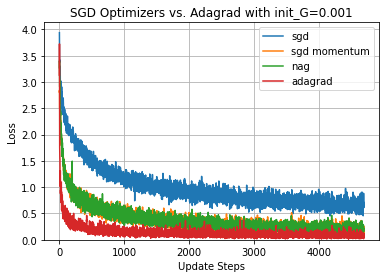

In [45]:
losses = [sgd_loss, sgd_momentum_loss, nag_loss, adagrad_losses[0.001]]
labels = ['sgd', 'sgd momentum', 'nag', 'adagrad']

plot_losses(losses, labels, 'SGD Optimizers vs. Adagrad with init_G=0.001')

## Optimizer 5: Adadelta

All of our update step equations can be written in the form of:

$$\theta_{t+1,i} = \theta_{t,i} + \Delta \theta_{t,i}$$

where $\Delta \theta_{t,i}$ is the size of the parameter update, i.e. in SGD we had: 

$$\Delta \theta_{t,i} = - \eta \cdot \nabla_\theta J(\theta_{t,i})$$

and in Adagrad we had: 

$$\Delta \theta_{t,i} = - \frac{\eta}{\sqrt{G_{t,i}}+\epsilon} \cdot \nabla_\theta J(\theta_{t,i}))$$

For Adadelta, to solve the problem of $G$ monotonically increasing we first replace $G_{t,i}$ with $E[g^2]_{t,i}$, an exponential moving average of the square of the gradients so far.

$$E[g^2]_{t,i} = \rho E[g^2]_{t-1,i} + (1-\rho)g^2_{t,i}$$

where $g_{t,i} = \nabla_\theta J(\theta_{t,i})$ - which we've done just to simplify the notation a little bit - and $\rho$ controls how much we care about the previous gradients in the exponential moving average, $\rho=0$ means we don't care about them at all.

Thus, we get an update step equation of:

$$\Delta \theta_t = - \frac{\eta}{\sqrt{E[g^2]_{t,i} + \epsilon}} \cdot g_{t,i}$$

Notice that the $\epsilon$ term has now moved inside the square root. The problem with above equation - and in fact all update equations seen so far - is the units of the update do not match the units of the parameters. To solve this they use a second exponential moving average, but this one is of the parameter updates.

To get the final Adadelta equation, we take our first attempt, but replace $\eta$ with an exponential moving average of the squared parameter updates:

$$E[\Delta \theta^2]_{t-1,i} = \rho E[\Delta \theta^2]_{t-2,i} + (1-\rho)\Delta \theta^2_{t-1,i}$$

Thus we get:

$$\Delta \theta_{t,i} = - \frac{\sqrt{E[\Delta \theta^2]_{t-1,i} + \epsilon}}{\sqrt{E[g^2]_{t,i}+\epsilon}} \cdot g_{t,i}$$

This means that we do not even need to use a learning rate value, however in the PyTorch implementation they do use one (which defaults to 1.0), so they end up with:

$$\Delta \theta_{t,i} = - \eta \cdot \frac{\sqrt{E[\Delta \theta^2]_{t-1,i} + \epsilon}}{\sqrt{E[g^2]_{t,i}+\epsilon}} \cdot g_{t,i}$$

In [46]:
class Adadelta:
    def __init__(self, model_params, lr=1.0, rho=0.9, eps=1e-6):
        self.model_params = list(model_params)
        self.lr = lr
        self.rho = rho
        self.eps = eps
        self.acc_grads = [torch.zeros_like(p) for p in self.model_params]
        self.acc_deltas = [torch.zeros_like(p) for p in self.model_params] 

    def zero_grad(self):
        for param in self.model_params:
            param.grad = None

    @torch.no_grad()
    def step(self):
        for param, acc_grad, acc_delta in zip(self.model_params, self.acc_grads, self.acc_deltas):
            acc_grad.mul_(self.rho).add_(param.grad * param.grad * (1 - self.rho))
            std = acc_grad.add(self.eps).sqrt()
            delta = acc_delta.add(self.eps).sqrt().div(std).mul(param.grad)
            param.sub_(self.lr * delta)
            acc_delta.mul_(self.rho).add_(delta * delta * (1 - self.rho))

In [47]:
optimizer = Adadelta(model.parameters())

In [48]:
adadelta_loss = train(train_iterator, model, optimizer, criterion, device)

100%|██████████| 469/469 [00:09<00:00, 47.25it/s]


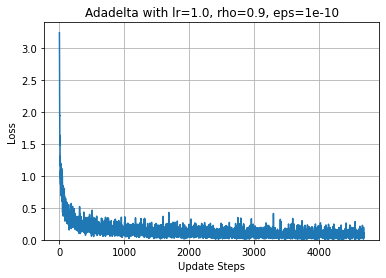

In [49]:
plot_loss(adadelta_loss, 'Adadelta with lr=1.0, rho=0.9, eps=1e-10')

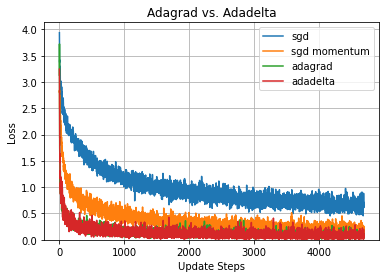

In [50]:
losses = [sgd_loss, sgd_momentum_loss, adagrad_losses[0.001], adadelta_loss]
labels = ['sgd', 'sgd momentum', 'adagrad', 'adadelta']

plot_losses(losses, labels, 'Adagrad vs. Adadelta')